In [1]:
from anomalib.data import MVTec
from anomalib.models import Fastflow,Patchcore
from anomalib.engine import Engine
import sys
from PIL import Image
from anomalib.deploy import TorchInferencer
import numpy as np
import cv2
from torch import as_tensor
from torchvision.transforms.v2.functional import to_dtype, to_image
import torch
import torchvision.models as models


c:\Users\ahmed\Desktop\anomaly-detection\.venv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [5]:
datamodule = MVTec(category='screw', num_workers=0)
model= Patchcore(backbone='resnet18')
engine = Engine(max_epochs = 5,
                accelerator = 'gpu')


INFO:anomalib.models.components.base.anomaly_module:Initializing Patchcore model.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
INFO:timm.models._hub:[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


In [ ]:
engine.fit(datamodule=datamodule, model=model)

INFO:anomalib.engine.engine:Overriding max_epochs from 5 with 1 for Patchcore


TypeError: Trainer.__init__() got an unexpected keyword argument 'weights_only'

In [ ]:
from anomalib import TaskType
from anomalib.deploy import ExportType
path_export_weights = engine.export(export_type=ExportType.TORCH,
                                    model=model)

INFO:root:Exported model to C:\Users\ahmed\Desktop\anomaly-detection\src\results\Patchcore\MVTec\screw\latest\weights\torch\model.pt


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [17]:
import matplotlib.pyplot as plt
def img_is_color(img):
    if len(img.shape) == 3:
        # Check the color channels to see if they're all the same.
        c1, c2, c3 = img[:, :, 0], img[:, :, 1], img[:, :, 2]
        if (c1 == c2).all() and (c2 == c3).all():
            return True

    return False


def show_image_list(list_images, path_image, list_titles=None, list_cmaps=None, grid=True, num_cols=2, figsize=(20, 10),
                    title_fontsize=30):
    '''
    Shows a grid of images, where each image is a Numpy array. The images can be either
    RGB or grayscale.

    Parameters:
    ----------
    images: list
        List of the images to be displayed.
    list_titles: list or None
        Optional list of titles to be shown for each image.
    list_cmaps: list or None
        Optional list of cmap values for each image. If None, then cmap will be
        automatically inferred.
    grid: boolean
        If True, show a grid over each image
    num_cols: int
        Number of columns to show.
    figsize: tuple of width, height
        Value to be passed to pyplot.figure()
    title_fontsize: int
        Value to be passed to set_title().
    '''

    assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), '%d imgs != %d cmaps' % (len(list_images), len(list_cmaps))

    num_images = len(list_images)
    num_cols = min(num_images, num_cols)
    num_rows = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):
        img = list_images[i]
        title = list_titles[i] if list_titles is not None else 'Image %d' % (i)
        cmap = list_cmaps[i] if list_cmaps is not None else (None if img_is_color(img) else 'gray')

        list_axes[i].imshow(img, cmap=cmap)
        list_axes[i].set_title(title, fontsize=title_fontsize)
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    plt.savefig(path_image)
    _ = plt.show()


Abnormal - pred_score: 0.5789


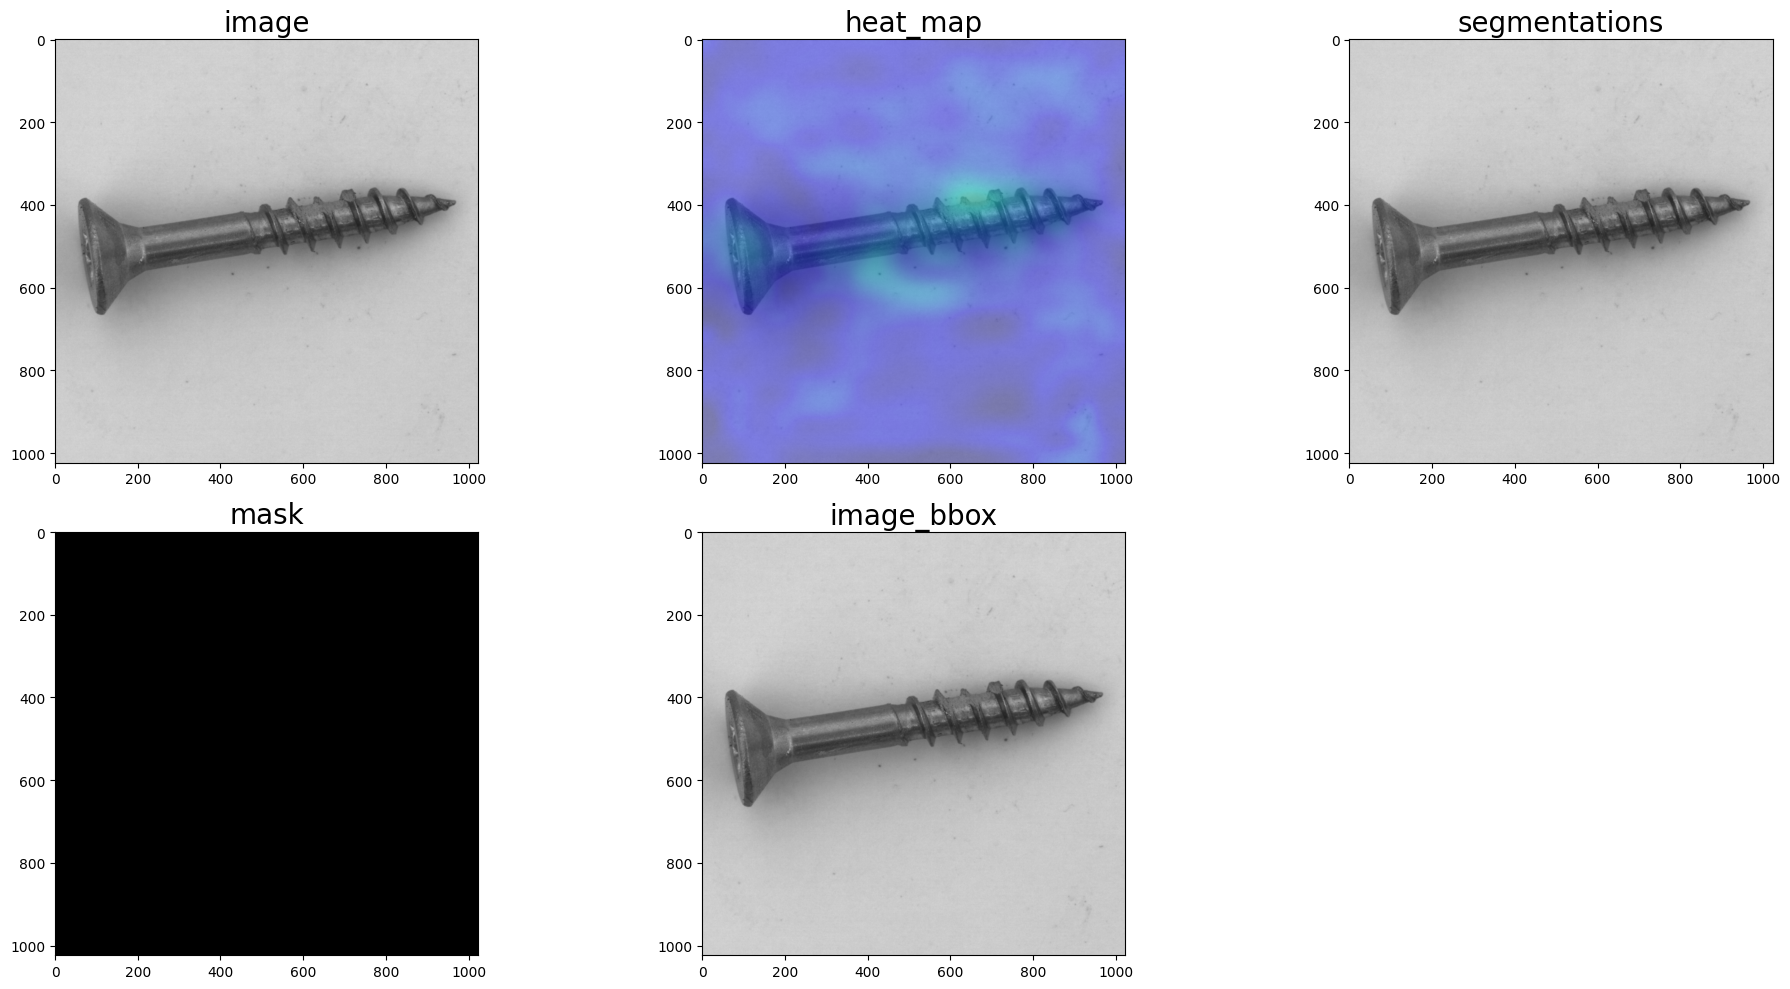

In [ ]:
from torchvision.transforms.v2 import Compose, Resize, CenterCrop, Normalize
from anomalib.deploy import TorchInferencer
import time

ckpt_path = "./results/Patchcore/MVTec/screw/v7/weights/torch/model.pt"
image_path = './datasets/MVTec/screw/test/thread_side/016.png'

# Load the exported model
inferencer = TorchInferencer(path=ckpt_path, device="cuda")

# Define standard transforms
transform = Compose([
    Resize((256, 256), antialias=True),
    CenterCrop((224, 224)),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Assign the transforms to the model
inferencer.model.transform = transform

start_time = time.time()
result = inferencer.predict(image=image_path)
end_time = time.time()
inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
print(f"Inference Time: {inference_time:.2f} ms")

# result.pred_score gives the score to be anomalous
if result.pred_label == 0:
    normal_score = 1 - result.pred_score
    print("Normal - pred_score: {:.4f}".format(normal_score))
else:
    print("Abnormal - pred_score: {:.4f}".format(result.pred_score))

# build the bounding box from the mask
image_bbox = result.image.copy()
# Find the contours of the white mask
contours, _ = cv2.findContours(result.pred_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Create the bbox around the white contours
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(image_bbox, (x, y), (x+w, y+h), (255, 0, 0), 2)

# stack three time the mask to simulate the three colour channels
mask = cv2.merge((result.pred_mask,result.pred_mask,result.pred_mask))
path_result = "./"
show_image_list(list_images=[result.image, result.heat_map, result.segmentations, mask, image_bbox],
                list_titles=['image', 'heat_map', 'segmentations', 'mask', 'image_bbox'],
                num_cols=3,
                figsize=(20, 10),
                grid=False,
                title_fontsize=20,
                path_image=path_result)

In [ ]:
import torch
import numpy as np
from PIL import Image
from anomalib.data import PredictDataset
from torch.utils.data import DataLoader

# Ensure the image path is correct


# Create dataset and dataloader
dataset = PredictDataset(image_path)  # Wrap in a list if necessary
dataloader = DataLoader(dataset, batch_size=1)

# Run inference using engine
result = engine.predict(ckpt_path='results/Patchcore/MVTec/screw/v7/weights/torch/model.pt' , dataloaders=dataloader)
print(result)


UnassignedError: ``self.trainer`` is not assigned yet.

In [22]:
print(engine.model)  # Should output the loaded model details


Patchcore(
  (model): PatchcoreModel(
    (feature_extractor): TimmFeatureExtractor(
      (feature_extractor): FeatureListNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (drop_block): Identity()
            (act1): ReLU(inplace=True)
            (aa): Identity()
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [ ]:
### Quality assurance -> Database -> Data analysis -> Preventive action -> Corrective action -> Quality Control